## Rescheduling 

In [1]:
import sys
import os

# Projektverzeichnis
project_root = os.path.abspath(os.path.join(os.getcwd(), '..', '..'))

# Füge dem sys.path hinzu, falls noch nicht vorhanden
if project_root not in sys.path:
    sys.path.append(project_root)

In [2]:
# Datenzugriff
from db_models import *

# Utils
import src.utils.visualization.gantt_diagram as gantt
import src.utils.rolling_process.scheduling_preparation as schedule_prep

# Solver Model
from src.models.cp import lateness_rescheduling as cp_late_reschedule

# Simulation
# from src.simulation.ProductionRollingSimulation import ProductionSimulation

# Extern
import pandas as pd

pd.set_option('display.max_rows', 21)

In [3]:
max_time = 60 * 15 # 15 min

In [4]:
this_version = "gt_v00"

In [5]:
Job.clone_jobs(referenced_version="base", new_version=this_version)
#JobOperation.clone_operations(referenced_version="base", new_version=this_version)

✅ 622 Jobs von Version 'base' nach Version 'gt_v00' kopiert.


## Laden des fertigen Datensatzes (3 Tage Ankunft)

In [6]:
# Jobs
df_jobs_times = Job.get_dataframe(version=this_version)
df_jobs_times = df_jobs_times[df_jobs_times.Arrival <= 60*24*3]
df_jobs_times

,Job,Routing_ID,Arrival,Ready Time,Deadline,Status,Version
0,J25-0000,8,77,1440,2760,open,gt_v00
1,J25-0001,6,127,1440,2645,open,gt_v00
2,J25-0002,0,194,1440,3800,open,gt_v00
3,J25-0003,2,238,1440,4273,open,gt_v00
4,J25-0004,3,280,1440,3284,open,gt_v00
...,...,...,...,...,...,...,...
63,J25-0063,3,4177,4320,6566,open,gt_v00
64,J25-0064,2,4240,4320,5907,open,gt_v00
65,J25-0065,4,4281,4320,7469,open,gt_v00
66,J25-0066,5,4299,4320,6540,open,gt_v00


In [7]:
# Routings
df_routings = RoutingOperation.get_dataframe()
df_routings

,Routing_ID,Operation,Machine,Processing Time
0,0,0,M00,29
1,0,1,M01,78
2,0,2,M02,9
3,0,3,M03,36
4,0,4,M04,49
...,...,...,...,...
95,9,5,M09,76
96,9,6,M05,47
97,9,7,M03,52
98,9,8,M04,90


In [8]:
df_jssp = schedule_prep.get_jssp_for_jobs(df_jobs_times, df_routings)
df_jssp

,Job,Routing_ID,Operation,Machine,Processing Time
0,J25-0000,8,0,M00,76
1,J25-0000,8,1,M01,69
2,J25-0000,8,2,M03,76
3,J25-0000,8,3,M05,51
4,J25-0000,8,4,M02,85
...,...,...,...,...,...
675,J25-0067,7,5,M06,88
676,J25-0067,7,6,M08,19
677,J25-0067,7,7,M09,48
678,J25-0067,7,8,M07,36


In [9]:
JobOperation.add_from_dataframe(df_jssp, version=this_version, status="open")

✅ 680 JobOperation-Einträge (Version 'gt_v00', Status 'open') wurden hinzugefügt oder aktualisiert.


### Params

In [10]:
day_length = 1440
day_numb = 0
day_start = day_length*day_numb 
day_end = day_start + day_length
print(f"Tag {day_numb:02d}: [{day_start}, {day_end})")

Tag 00: [0, 1440)


## Tag 1 (init. Tag - kein Rescheduling)

In [11]:
day_numb = 1

day_start = day_length*day_numb 
day_end = day_start + day_length
print(f"Tag {day_numb:02d}: [{day_start}, {day_end})")

Tag 01: [1440, 2880)


In [12]:
# alle aktuelle "offenen" Jobs
df_job_times_curr = Job.get_dataframe(version=this_version, arrival_time_max=day_start, status="open")
df_job_times_curr

,Job,Routing_ID,Arrival,Ready Time,Deadline,Status,Version
0,J25-0000,8,77,1440,2760,open,gt_v00
1,J25-0001,6,127,1440,2645,open,gt_v00
2,J25-0002,0,194,1440,3800,open,gt_v00
3,J25-0003,2,238,1440,4273,open,gt_v00
4,J25-0004,3,280,1440,3284,open,gt_v00
5,J25-0005,1,487,1440,3743,open,gt_v00
6,J25-0006,9,773,1440,3260,open,gt_v00
7,J25-0007,5,905,1440,3124,open,gt_v00
8,J25-0008,4,967,1440,3593,open,gt_v00
9,J25-0009,7,982,1440,3575,open,gt_v00


In [13]:
#  JSSP zu allen "offenen" Jobs
df_jssp_temp = schedule_prep.get_jssp_for_jobs(df_job_times_curr, df_routings)
df_jssp_temp

,Job,Routing_ID,Operation,Machine,Processing Time
0,J25-0000,8,0,M00,76
1,J25-0000,8,1,M01,69
2,J25-0000,8,2,M03,76
3,J25-0000,8,3,M05,51
4,J25-0000,8,4,M02,85
...,...,...,...,...,...
155,J25-0015,5,5,M09,72
156,J25-0015,5,6,M00,47
157,J25-0015,5,7,M06,65
158,J25-0015,5,8,M04,6


In [14]:
#  JSSP zu allen "offenen" Jobs, mit "offenen" Operationen
df_jobs_ops = JobOperation.get_dataframe(version=this_version, jobs=df_jssp_temp.Job.tolist(), status="open")
df_jssp_curr = df_jssp_temp.merge(df_jobs_ops[['Job', 'Operation']], on=['Job', 'Operation'], how='inner')
df_jssp_curr

,Job,Routing_ID,Operation,Machine,Processing Time
0,J25-0000,8,0,M00,76
1,J25-0000,8,1,M01,69
2,J25-0000,8,2,M03,76
3,J25-0000,8,3,M05,51
4,J25-0000,8,4,M02,85
...,...,...,...,...,...
155,J25-0015,5,5,M09,72
156,J25-0015,5,6,M00,47
157,J25-0015,5,7,M06,65
158,J25-0015,5,8,M04,6


### A) Scheduling

In [15]:
import pandas as pd
import random
from collections import defaultdict

def giffler_thompson_schedule(
    df_jssp: pd.DataFrame,
    df_arrivals_deadlines: pd.DataFrame,
    priority_rule: str = "SPT",
    log_on: bool = True
) -> pd.DataFrame:
    """
    Giffler-Thompson-Algorithmus mit Ready Time (für Planung) und Arrival (für Ausgabe).
    Rückgabe mit Lateness, Tardiness, Earliness.

    Rückgabe:
    - df_schedule: DataFrame mit Zeitplan und Auswertung
    - makespan: maximale Endzeit
    - total_abs_lateness: Summe der absoluten Lateness der letzten Operationen je Job
    """

    if log_on: 
        print(f'Giffler-Thompson-Algorithmus mit Prioritätsregel \"{priority_rule}\" gestartet ...\n')

    df = df_jssp.copy().sort_values(['Job', 'Operation']).reset_index(drop=True)
    machines = set(df['Machine'])
    jobs = df['Job'].unique()

    ready_time = df_arrivals_deadlines.set_index("Job")["Ready Time"].to_dict()
    arrival = df_arrivals_deadlines.set_index("Job")["Arrival"].to_dict()
    deadline = df_arrivals_deadlines.set_index("Job")["Deadline"].to_dict()

    job_op_ready = {job: 0 for job in jobs}
    machine_available = {m: 0 for m in machines}
    job_op_index = {job: 0 for job in jobs}

    job_ops = defaultdict(list)
    for _, row in df.iterrows():
        job_ops[row['Job']].append((row['Operation'], row['Machine'], row['Processing Time']))

    result = []
    remaining = sum(len(v) for v in job_ops.values())

    while remaining > 0:
        candidates = []
        for job in jobs:
            idx = job_op_index[job]
            if idx < len(job_ops[job]):
                op_id, m, d = job_ops[job][idx]
                est = max(job_op_ready[job], machine_available[m], ready_time[job])
                candidates.append((est, d, job, op_id, m))

        min_est = min(c[0] for c in candidates)
        conflict_ops = [c for c in candidates if c[0] == min_est]

        if priority_rule == "SPT":
            selected = min(conflict_ops, key=lambda x: x[1])
        elif priority_rule == "EDF" or priority_rule == "EDD":
            selected = min(conflict_ops, key=lambda x: deadline[x[2]])  # x[2] ist der Job
        else:  # RANDOM oder unbekannt
            selected = random.choice(conflict_ops)

        est, d, job, op_id, m = selected
        start = est
        end = start + d

        result.append({
            'Job': job,
            'Operation': op_id,
            'Machine': m,
            'Start': start,
            'Processing Time': d,
            'End': end
        })

        job_op_ready[job] = end
        machine_available[m] = end
        job_op_index[job] += 1
        remaining -= 1

    # Berechnung von Lateness, Tardiness, Earliness
    for row in result:
        job = row['Job']
        lateness_val = row['End'] - deadline[job]
        row.update({
            "Arrival": arrival[job],
            "Deadline": deadline[job],
            "Lateness": lateness_val,
            "Tardiness": max(0, lateness_val),
            "Earliness": max(0, -lateness_val)
        })

    df_schedule = pd.DataFrame(result).sort_values(['Start', 'Job', 'Operation']).reset_index(drop=True)

    last_ops = df_schedule.groupby("Job")["Operation"].max()
    last_op_index_tuples = list(zip(last_ops.index, last_ops.values))
    mask_last_ops = df_schedule.set_index(["Job", "Operation"]).index.isin(last_op_index_tuples)
    total_abs_lateness = df_schedule[mask_last_ops]["Lateness"].abs().sum()

    ende = df_schedule['End'].max()

    if log_on:
        print("\nPlan-Informationen:")
        print(f"  Anzahl Jobs            : {len(jobs)}")
        print(f"  Anzahl Maschinen       : {len(machines)}")
        print(f"  Anzahl Operationen     : {len(df_schedule)}")
        print(f"  Ende                   : {ende}")
        print(f"  Summe Absolute Lateness: {total_abs_lateness}")

    return df_schedule

In [16]:
# Scheduling
df_schedule = giffler_thompson_schedule(
    df_jssp=df_jssp,
    df_arrivals_deadlines=df_jobs_times,
    priority_rule="EDF",
    log_on=True
)

df_schedule

Giffler-Thompson-Algorithmus mit Prioritätsregel "EDF" gestartet ...


Plan-Informationen:
  Anzahl Jobs            : 68
  Anzahl Maschinen       : 10
  Anzahl Operationen     : 680
  Ende                   : 6906
  Summe Absolute Lateness: 45738


,Job,Operation,Machine,Start,Processing Time,End,Arrival,Deadline,Lateness,Tardiness,Earliness
0,J25-0000,0,M00,1440,76,1516,77,2760,-1244,0,1244
1,J25-0001,0,M01,1440,46,1486,127,2645,-1159,0,1159
2,J25-0007,0,M02,1440,84,1524,905,3124,-1600,0,1600
3,J25-0006,0,M01,1486,85,1571,773,3260,-1689,0,1689
4,J25-0001,1,M00,1516,37,1553,127,2645,-1092,0,1092
...,...,...,...,...,...,...,...,...,...,...,...
675,J25-0038,9,M05,6738,43,6781,2907,7417,-636,0,636
676,J25-0046,7,M03,6743,98,6841,3281,7453,-612,0,612
677,J25-0061,9,M07,6743,45,6788,4141,7413,-625,0,625
678,J25-0046,8,M09,6841,22,6863,3281,7453,-590,0,590


In [17]:
"""
json_schedule = df_schedule.to_dict(orient='records')

Schedule.add_schedule(
    data=json_schedule,
    date=day_numb,
    version=this_version
)
"""

"\njson_schedule = df_schedule.to_dict(orient='records')\n\nSchedule.add_schedule(\n    data=json_schedule,\n    date=day_numb,\n    version=this_version\n)\n"

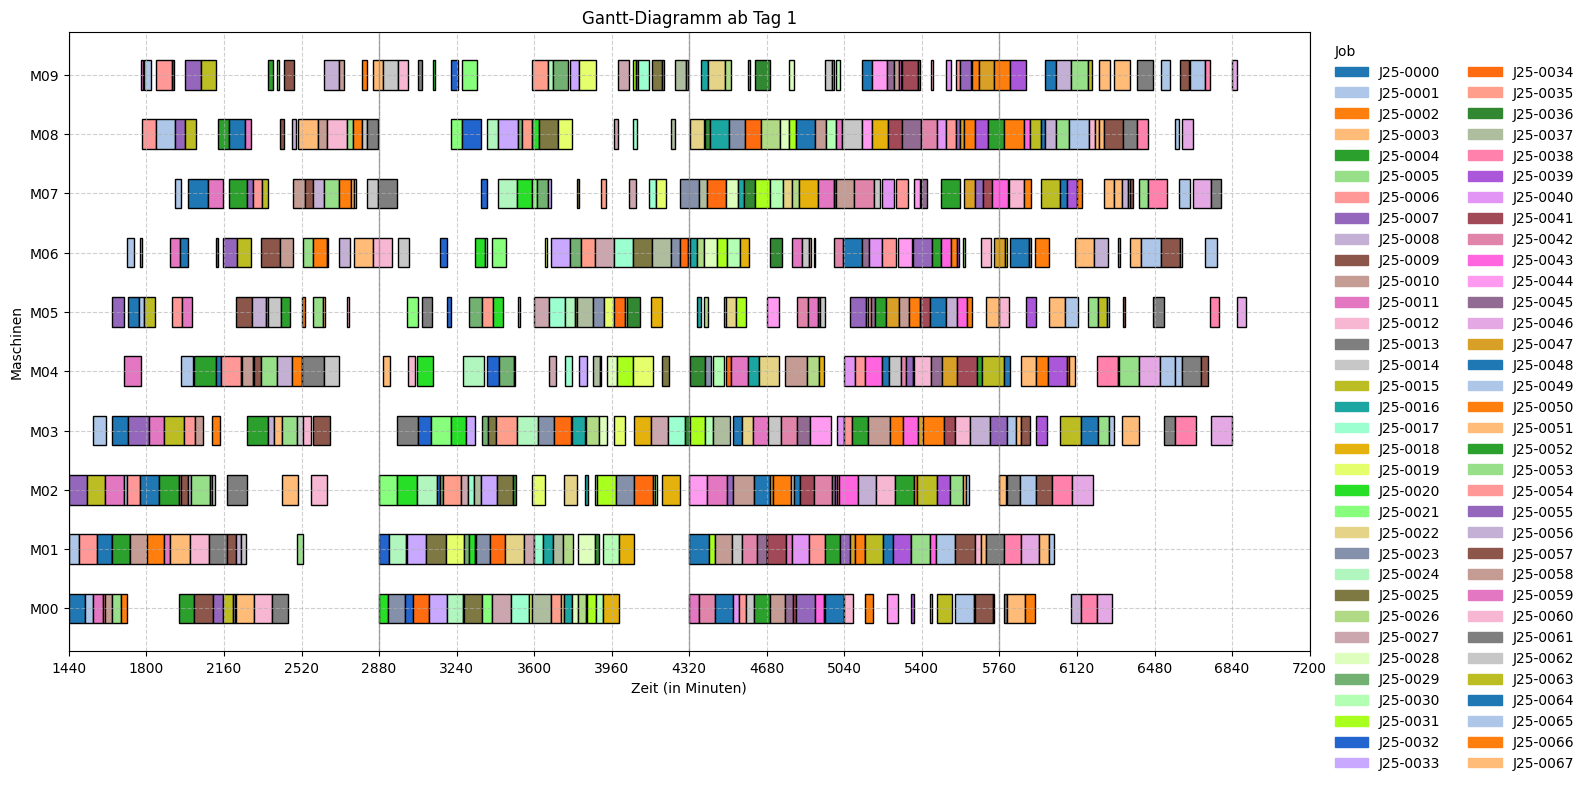

In [18]:
gantt.get_plot(df_schedule, perspective="Machine", title=f"Gantt-Diagramm ab Tag {day_numb}")

In [19]:
-

SyntaxError: invalid syntax (476313318.py, line 1)

### B) Simulation

In [ ]:
simulation = ProductionSimulation(df_schedule, sigma=0.2)
df_execution = simulation.run(start_time = day_start, end_time=day_end)

In [ ]:
gantt.get_plot(df_execution, perspective="Machine", title=f"Gantt-Diagramm für Tag {day_numb}")

In [ ]:
df_ops_finished = df_execution[df_execution.End < day_end]
JobOperation.add_from_dataframe(df_ops_finished, version=this_version, status="finished")
df_ops_finished

In [ ]:
JobOperation.update_closed_jobs_from_operations(version=this_version)

In [ ]:
df_ops_in_progess = df_execution[df_execution.End >= day_end]
JobOperation.add_from_dataframe(df_ops_in_progess, version=this_version, status="in progress")
df_ops_in_progess

## II) Tag 2

In [ ]:
this_version = this_version

In [ ]:
day_numb = 2

day_start = day_length*day_numb 
day_end = day_start + day_length
print(f"Tag {day_numb:02d}: [{day_start}, {day_end})")

In [ ]:
# alle aktuelle "offenen" Jobs
df_jobs_times_curr = Job.get_dataframe(version=this_version, arrival_time_max=day_start, status="open")
df_jobs_times_curr

In [ ]:
#  JSSP zu allen "offenen" Jobs (auch fertige Operationen)
df_jssp_temp = schedule_prep.get_jssp_for_jobs(df_jobs_times_curr, df_routings)


#  JSSP zu allen "offenen" Jobs, mit "offenen" Operationen
df_jobs_ops = JobOperation.get_dataframe(version=this_version, jobs=df_jssp_temp.Job.tolist(), status="open")
df_jssp_curr = df_jssp_temp.merge(df_jobs_ops[['Job', 'Operation']], on=['Job', 'Operation'], how='inner')
df_jssp_curr

In [ ]:
# Relevante 
df_ops_in_progess = JobOperation.get_dataframe(version=this_version, status="in progress")
df_ops_in_progess

In [ ]:
## Hole den vorherigen Schedule
df_schedule = Schedule.get_schedule_as_dataframe(date=day_numb-1, version=this_version)

# Hole die offenen Operationen für die enthaltenen Jobs
df_open_ops = JobOperation.get_dataframe(version=this_version, jobs=df_schedule["Job"].unique().tolist(), status="open")

# Mache ein Inner Join auf ["Job", "Operation"]
df_schedule_prev = df_schedule.merge(df_open_ops[["Job", "Operation"]], on=["Job", "Operation"], how="inner")
df_schedule_prev

In [ ]:
df_jssp_curr

In [ ]:
# Entfernung der Jobs (wo nur noch Operation in progress)
df_jobs_times_curr = df_jobs_times_curr[df_jobs_times_curr["Job"].isin(df_jssp_curr["Job"].unique())].copy()
df_jobs_times_curr

### Rescheduling

#### Old Version

$$
min   Z = r \cdot \sum_{j \in \text{Jobs}} \left( w_t \cdot \text{Tardiness}_j + w_e \cdot \text{Earliness}_j \right) + (1 - r) \cdot \sum_{(j,o) \in \text{DevOps}} \left| \text{Start}_{j,o} - \text{Start}_{j,o}^{\text{original}} \right|
$$


In [ ]:
df_schedule = cp_late_reschedule.solve_jssp_by_tardiness_and_earliness_with_devpen(df_jssp_curr, df_jobs_times_curr, 
                                                                                   df_ops_in_progess, 
                                                                                   df_original_plan = df_schedule_prev,
                                                                                   w_t = 5,
                                                                                   r = 0.2, # 20% Lateness, 80% Deviation
                                                                                   reschedule_start = day_start, 
                                                                                   msg=False, timeLimit=max_time, gapRel= 0.001)

gantt.get_plot(df_schedule, perspective="Machine", title=f"Gantt-Diagramm für Schedule ab Tag {day_numb}")

$$
Z = \alpha \cdot \left[
r \cdot \sum_{j \in \text{Jobs}} \left( w_t \cdot \max(0, C_j - D_j) + w_e \cdot \max(0, D_j - C_j) \right)
+ (1 - r) \cdot \sum_{(j,o) \in \text{DevOps}} \left| S_{j,o} - S_{j,o}^{\text{orig}} \right|
\right]
- (1 - \alpha) \cdot \sum_{j \in \text{Jobs}} S_j^{\text{first}}
$$


In [ ]:
df_schedule = cp_late_reschedule.solve_jssp_advanced(df_jssp_curr, df_jobs_times_curr, df_ops_in_progess, 
                                                      df_original_plan = df_schedule_prev, w_t = 5,
                                                       r = 0.2, # 20% Lateness, 80% Deviation
                                                       reschedule_start = day_start, 
                                                       msg=False, timeLimit=max_time, gapRel= 0.001,
                                                      alpha =0.90)

gantt.get_plot(
    df_schedule, perspective="Machine",
    title=f"Gantt-Diagramm für Schedule ab Tag {day_numb}"
)

# Simulation 

In [ ]:
simulation = ProductionSimulation(df_schedule, sigma=0.2)
df_execution = simulation.run(start_time = day_start, end_time=day_end)

In [ ]:
# previous "in progress" operations -> "finished"
df_ops_in_progess_prev = JobOperation.get_dataframe(version=this_version, status="in progress")
if df_ops_in_progess_prev is not None and not df_ops_in_progess_prev.empty:
    df_ops_in_progess_prev_finished = df_ops_in_progess_prev[df_ops_in_progess_prev.End <= day_end]
    JobOperation.add_from_dataframe(df_ops_in_progess_prev_finished, version=this_version, status="finished")


In [ ]:
# "finished" operations from current simulation
df_ops_finished = df_execution[df_execution.End < day_end]
JobOperation.add_from_dataframe(df_ops_finished, version=this_version, status="finished")
JobOperation.update_closed_jobs_from_operations(version=this_version)
df_ops_finished

In [ ]:
# "in progress" operations from current simulation
df_ops_in_progess = df_execution[df_execution.End >= day_end]
JobOperation.add_from_dataframe(df_ops_in_progess, version=this_version, status="in progress")
df_ops_in_progess   

In [ ]:
# consistency check
df_ops_in_progess = JobOperation.get_dataframe(version=this_version, status="in progress")
df_ops_in_progess